## N차 과제 - Time Series Analysis_주가예측

- 주제: 시계열 모델을 주가 데이터에 대한 시계열 예측 및 분석
- 데이터: 주식 데이터(크롤링 or 라이브러리로 데이터 불러오기)
- 사용 라이브러리: yfinance, datareader, statsmodels, matplotlib etc.

In [2]:
!pip install yfinance
import pandas as pd
import yfinance as yf
import datetime
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose

In [4]:
df = pd.read_csv('C:/Users/LG/Documents/카카오톡 받은 파일/sam_stock.csv')

In [5]:
df

,Date,Open,High,Low,Close,Adj Close,Volume
0,2021-10-01,73900.0,74000.0,72900.0,73200.0,69039.710938,15803395
1,2021-10-05,73000.0,73000.0,71400.0,72200.0,68096.539062,24013921
2,2021-10-06,72600.0,72800.0,71200.0,71300.0,67247.687500,18956962
3,2021-10-07,71600.0,72100.0,71300.0,71600.0,67530.648438,13683532
4,2021-10-08,72300.0,72400.0,71500.0,71500.0,67436.320312,14043287
...,...,...,...,...,...,...,...
732,2024-09-26,63900.0,64900.0,63700.0,64700.0,64700.000000,37566015
733,2024-09-27,64700.0,65400.0,64200.0,64200.0,64200.000000,28433030
734,2024-09-30,64200.0,64300.0,61500.0,61500.0,61500.000000,32694163
735,2024-10-02,60500.0,61900.0,59900.0,61300.0,61300.000000,28473536


### 1. EDA 및 전처리

1.1 분석을 위해 사용할 특정 주식(1개)의 데이터를 불러오거나 크롤링하여 가져오세요(**최소 3년 이상의 데이터 추출 권고**).

In [ ]:
!pip install --upgrade pandas

1.2 결측치가 있는지 확인하고 있다면 제거해주세요.

In [7]:
print(df.isnull().sum())

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64


1.3 일자를 인덱스로 설정하고 시간 순서대로 정렬하세요.

In [9]:
# 인덱스를 'Date'로 설정
df.index = pd.to_datetime(df.index)

# 시간 순서대로 정렬
sam = df.sort_index()

# 결과 확인
print(df.head())

                                     Date     Open     High      Low    Close  \
1970-01-01 00:00:00.000000000  2021-10-01  73900.0  74000.0  72900.0  73200.0   
1970-01-01 00:00:00.000000001  2021-10-05  73000.0  73000.0  71400.0  72200.0   
1970-01-01 00:00:00.000000002  2021-10-06  72600.0  72800.0  71200.0  71300.0   
1970-01-01 00:00:00.000000003  2021-10-07  71600.0  72100.0  71300.0  71600.0   
1970-01-01 00:00:00.000000004  2021-10-08  72300.0  72400.0  71500.0  71500.0   

                                  Adj Close    Volume  
1970-01-01 00:00:00.000000000  69039.710938  15803395  
1970-01-01 00:00:00.000000001  68096.539062  24013921  
1970-01-01 00:00:00.000000002  67247.687500  18956962  
1970-01-01 00:00:00.000000003  67530.648438  13683532  
1970-01-01 00:00:00.000000004  67436.320312  14043287  


1.4 수정종가(adj close)와 거래량(volume)을 시각화하세요.

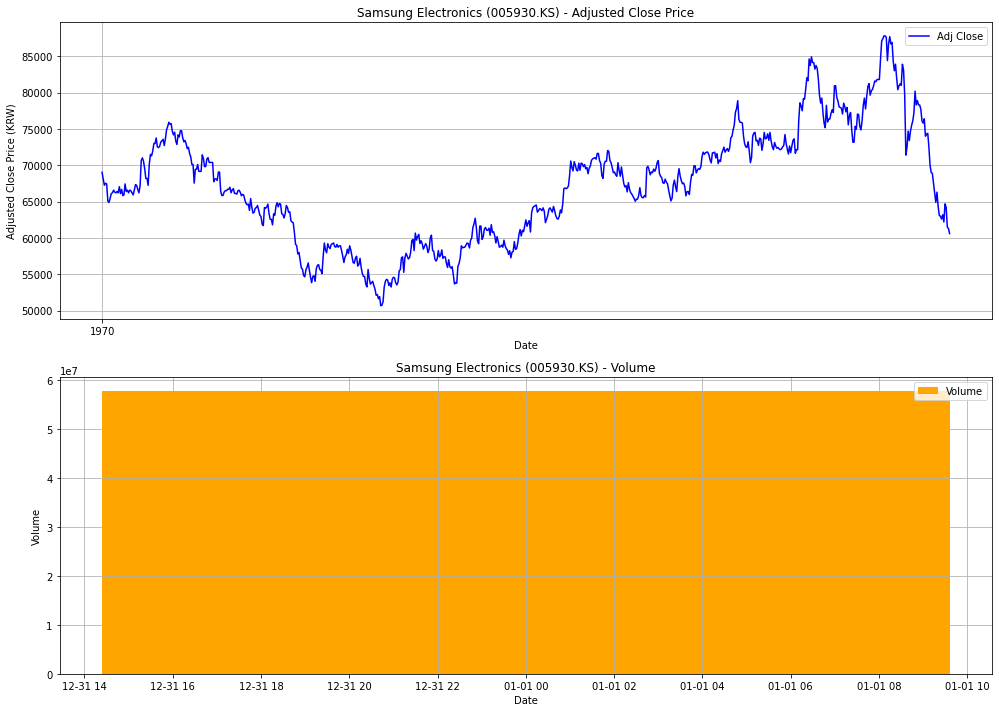

In [10]:
# 시각화 설정
plt.figure(figsize=(14, 10))

# 수정 종가 시각화
plt.subplot(2, 1, 1)
plt.plot(df['Adj Close'], color='blue', label='Adj Close')
plt.title('Samsung Electronics (005930.KS) - Adjusted Close Price')
plt.xlabel('Date')
plt.ylabel('Adjusted Close Price (KRW)')
plt.legend()
plt.grid()

# 거래량 시각화
plt.subplot(2, 1, 2)
plt.bar(df.index, df['Volume'], color='orange', label='Volume')
plt.title('Samsung Electronics (005930.KS) - Volume')
plt.xlabel('Date')
plt.ylabel('Volume')
plt.legend()
plt.grid()

# 레이아웃 조정
plt.tight_layout()
plt.show()

1.5 위 시각화 과정을 통해 알 수 있는 내용에 대해 작성하세요.

In [ ]:
#삼성전자의 주식은2022년 9월부터 2024년 9월까지 수정 종가가 우상향하고 있다.
#그러다가 2024년 9월을 기점으로 하향률을 보이고 있다.

#거래량은 2024년 1월이 가장 높으며  1월을 기점으로 거래량이 상승하고 있다.

### 2. 추세 및 정상성 검정

2.1 시계열 데이터의 정상성을 검증하도록 하겠습니다. 시계열 데이터 말하는 정상성(stationarity)이 무엇인지 왜 해야 하며 비정상성의 해결 방법에는 무엇이 있는지 작성하세요.

In [ ]:
#정상성(stationarity)은 시계열 데이터의 통계적 특성이 시간에 따라 일정하다는 것을 의미. 
#시계열의 평균, 분산, 공분산이 시간에 따라 변화하지 않는 특성을 말한다.

#정상성을 검증해야 하는 이유는 예측과 분석을 해야 하기 때문이다.

#비정상성의 해결방법에는 차분, 로그변환, 제곱근변환, 트렌드 제거, 계절 조정, 결합변환이 있다

2.2 먼저 ADF Test를 수행하겠습니다. statsmodels의 adfuller 라이브러리를 import 한 후 수정 종가에 대한 검정을 수행하고 결과를 출력하세요(p-value 포함).

ADF Test란? - https://hongl.tistory.com/98

In [11]:
# ADF 검정 수행
result = adfuller(df['Adj Close'])

# 결과 출력
print('ADF Statistic:', result[0])
print('p-value:', result[1])
print('Critical Values:')
for key, value in result[4].items():
    print(f'   {key}: {value}')

ADF Statistic: -1.5807204454231136
p-value: 0.49327061136011974
Critical Values:
   1%: -3.439290485895927
   5%: -2.8654856985173414
   10%: -2.568871126669587


2.3 ADF Test 결과를 해석하세요.

In [ ]:
# ADF 통계량은 -1.5791로, 이 값은 주어진 임계값과 비교할 때, 시계열이 비정상적일 가능성을 나타낸다.

# p-value가 0.4941로, 일반적으로 사용되는 유의 수준인 0.05보다 훨씬 크다. 이는 귀무가설(H0, 즉 "시계열이 비정상적이다")을 기각할 수 없음을 의미한다. 즉, 시계열 데이터가 비정상적이라는 가정을 받아들여야 한다.
# Critical Values:
# 주어진 임계값들과 ADF 통계량을 비교해보면:
#1% 수준의 임계값: -3.4393, 5% 수준의 임계값: -2.8655, 10% 수준의 임계값: -2.5689
# ADF 통계량인 -1.5791은 모든 임계값보다 크므로, 이 시계열 데이터가 정상적이지 않음을 확인할 수 있다.

2.4 ACF 그래프와 PACF 그래프를 그려보도록 하겠습니다. 먼저 ACF와 PACF 각각이 어떻게 다른지 설명하세요.

In [ ]:
#ACF: 전체적인 상관 관계를 보여줌. 과거 시점의 모든 영향을 다 포함하여 상관을 측정.
##또한 시차(lag)에 따라 시계열 데이터의 자기 상관을 측정. 즉, 시차가 커질수록 데이터가 얼마나 과거의 값과 연관이 있는지 보여줌.
#PACF: 직접적인 상관 관계만을 보여줌. 중간에 다른 시점의 영향을 제거한 순수한 상관 측정.

2.5 statsmodels의 plot_acf, plot_pacf 라이브러리를 import하고 Adj close값에 대한 ACF, PACF 그래프를 출력하세요.

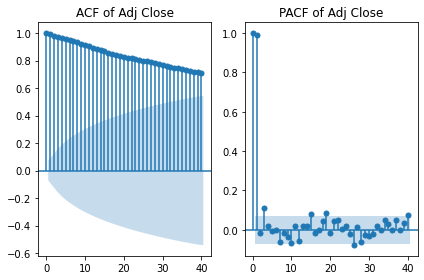

In [12]:
# ACF 그래프
plt.subplot(1, 2, 1)
plot_acf(df['Adj Close'], ax=plt.gca(), lags=40)
plt.title('ACF of Adj Close')

# PACF 그래프
plt.subplot(1, 2, 2)
plot_pacf(df['Adj Close'], ax=plt.gca(), lags=40)
plt.title('PACF of Adj Close')

plt.tight_layout()
plt.show()

2.6 결과를 해석하세요.

In [ ]:
#ACF그래프는 시차가 커질수록 우하향 곡선을 이루고 있다. ACF가 천천히 감소하면 데이터가 비정상적일 가능성이 있고 ACF가 빠르게 감소하면 데이터가 정상적일 수 있다.
#PACF그래프는 첫번째 값이 높게 나타난다. 이는 현재시점이 1단계 이전의 시점과 강한 상관이 있음을 의미한다.
##그후 값이 빠르게 감소하므로, 그 시차 이후의 상관이 크지 않다는 것을 나타낸다. 이는 AR(자기회귀)모델이 적합할 수 있음을 나타낸다.

2.7 마지막으로 계절성이 있는지 여부를 확인하겠습니다. statsmodels의 seasonal_decompose 라이브러리를 import하고 plot을 출력하세요.

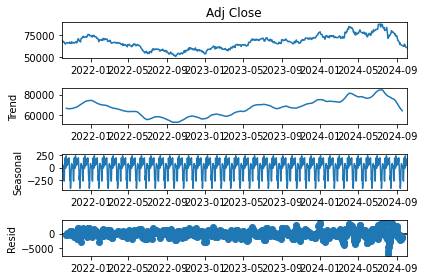

In [15]:
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt

df['Date'] = pd.to_datetime(df['Date'])  # 날짜 형식 변환
df.set_index('Date', inplace=True)  # 인덱스를 날짜로 설정

# 데이터의 시계열 분해 (연속적인 일간 데이터로 리샘플링 후 수행)
df_resampled = df['Adj Close'].resample('D').interpolate()

# 시계열 분해 (추세, 계절성, 잔차)
result = seasonal_decompose(df_resampled, model='additive', period=30)

# 시계열 분해 결과 시각화
result.plot()
plt.show()

2.8 위 결과를 해석하세요.

In [ ]:
#1.추세 : 2022년9월을 기점으로 시간이 지남에 따라 데이터가 상승한다. 이는 장기적으로
#이는 장기적으로 일정한 방향으로 변화하고 있다는 것을 의미한다. 상승추세가 뚜렷하므로
#주식가격이 장기적으로 오르고 있다.

#2.잔차 : 추세와 계절성을 제거한 후 남은 부분으로, 주로 설명되지 않은 불규칙적인 변동을 나타낸다.
#그래프를 보면 잔차가 큰 변동을 보이므로, 데이터에 비정상적인 변동이 많다는 것을 의미한다.

#3.계절성 : 일정한 패턴이 반복되는지 여부를 통해, 주가나 가격의 계절적 요인에 대한 통찰을 얻을 수 있다.
#그래프를 보면 일정 주기마다 반복되는 패턴을 보인다. 따라서 일정한 주기로 발생하는 계절성이 있다는 것을 의미한다.

2.9 위에서 진행한 검정 과정 및 시각화 결과를 종합해봤을 때 현 데이터는 비정상성임을 알 수 있습니다. 따라서 차분을 통해 이를 해결하도록 하겠습니다. 먼저 차분이 어떤 것인지에 대해 설명하세요.

In [ ]:
#차분(differencing)은 시계열 데이터의 비정상성을 해결하기 위해 사용되는 기법. 비정상성은 데이터의 평균, 분산, 공분산 등이 시간에 따라 변하는 경우를 의미함. 
#차분은 이러한 비정상성을 줄이거나 없애기 위해 데이터의 특정 시점과 이전 시점의 차이를 계산하는 방법이다.
#차분의 장점:
#-비정상성 제거-> 차분을 통해 시계열 데이터의 평균과 분산을 안정화시킬 수 있다.
#-모델링 용이-> 비정상성을 제거한 데이터는 ARIMA(자기회귀 적분 이동 평균)와 같은 통계 모델링 기법을 적용하기에 더 적합하다.

2.10 1차 차분을 진행하도록 하겠습니다. diff() 함수를 활용해 1차 차분을 진행한 후 ADF Test를 수행하여 정상성 여부를 확인하세요.

In [16]:
# 1차 차분 진행
sam_diff = sam['Adj Close'].diff().dropna()

# 1차 차분 데이터에 대해 ADF Test 수행
adf_result_diff = adfuller(sam_diff)

# ADF Test 결과 출력
adf_statistic_diff = adf_result_diff[0]
p_value_diff = adf_result_diff[1]
critical_values_diff = adf_result_diff[4]

# 결과 출력
print(f"ADF Statistic: {adf_statistic_diff}")
print(f"p-value: {p_value_diff}")
print("Critical Values:")
for key, value in critical_values_diff.items():
    print(f"   {key}: {value}")

ADF Statistic: -21.003861131707435
p-value: 0.0
Critical Values:
   1%: -3.439290485895927
   5%: -2.8654856985173414
   10%: -2.568871126669587


2.11 추가로 위에서 그려보았던 plot들을 다시 그려보면서 비교를 통해 정상성 여부를 확인해보도록 하겠습니다. ACF PACF plot, 계절성 분해 plot을 그려보세요.

In [19]:
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt

# 1. 데이터 확인 (Adj Close 값 확인)
print("원본 데이터 (Adj Close):")
print(sam['Adj Close'])

# 2. 리샘플링 후 NaN 값 확인 및 데이터 길이 출력
sam_daily = sam['Adj Close'].resample('D').mean().interpolate()  # 일별 리샘플링 후 NaN 보간
print("\n리샘플링 후 데이터:")
print(sam_daily)
print("\nNaN 값 개수:", sam_daily.isna().sum())  # NaN 값이 있는지 확인
print("리샘플링 후 데이터 길이:", len(sam_daily))

# 3. 차분 후 데이터 확인
sam_diff = sam_daily.diff().dropna()
print("\n차분 후 데이터:")
print(sam_diff)

# 4. 시계열 분해 (데이터가 충분하지 않을 경우 주기를 조정)
if len(sam_diff) >= 60:  # 최소한 60개 이상의 데이터가 필요
    result_diff = seasonal_decompose(sam_diff, model='additive', period=30)  # 주기를 30으로 설정
    
    # 5. 시계열 분해 결과 시각화
    result_diff.plot()
    plt.show()
else:
    print("차분 후 데이터가 충분하지 않아 시계열 분해가 불가능합니다.")


원본 데이터 (Adj Close):
1970-01-01 00:00:00.000000000    69039.710938
1970-01-01 00:00:00.000000001    68096.539062
1970-01-01 00:00:00.000000002    67247.687500
1970-01-01 00:00:00.000000003    67530.648438
1970-01-01 00:00:00.000000004    67436.320312
                                     ...     
1970-01-01 00:00:00.000000732    64700.000000
1970-01-01 00:00:00.000000733    64200.000000
1970-01-01 00:00:00.000000734    61500.000000
1970-01-01 00:00:00.000000735    61300.000000
1970-01-01 00:00:00.000000736    60600.000000
Name: Adj Close, Length: 737, dtype: float64

리샘플링 후 데이터:
1970-01-01    67207.110165
Freq: D, Name: Adj Close, dtype: float64

NaN 값 개수: 0
리샘플링 후 데이터 길이: 1

차분 후 데이터:
Series([], Freq: D, Name: Adj Close, dtype: float64)
차분 후 데이터가 충분하지 않아 시계열 분해가 불가능합니다.


### 3. 예측

3.1 데이터의 정상성을 확인했으니 본격적으로 예측 및 분석을 진행해보도록 하겠습니다.

아래 코드는 예시이므로 예시에서 사용된 모델이 아닌 다른 모델(ex. ARIMAX, ARCH/GARCH, LSTM, Transformer, DLinear etc.)를 사용하고 애플이 아닌 다른 주식을 사용해 예측 및 분석을 진행해주세요(**위에서 진행한 과정 역시 모두 예시이므로 새로운 주식에 대한 전처리 및 정상성 검정을 새로 진행해야 함**).

In [21]:
from statsmodels.tsa.arima.model import ARIMA

In [26]:
import pandas as pd

# 1. 데이터 불러오기
sam = pd.read_csv('C:/Users/LG/Documents/카카오톡 받은 파일/sam_stock.csv', parse_dates=['Date'], index_col='Date')

# 2. 리샘플링 후 NaN 값 처리
sam_daily = sam['Adj Close'].resample('D').mean().interpolate()

# 3. 차분을 계산하여 새로운 컬럼에 저장
sam['Adj Close Differenced'] = sam_daily.diff()

# 4. 결과 확인
print(sam[['Adj Close', 'Adj Close Differenced']].dropna())  # NaN 제거 후 출력


               Adj Close  Adj Close Differenced
Date                                           
2021-10-05  68096.539062            -235.792969
2021-10-06  67247.687500            -848.851562
2021-10-07  67530.648438             282.960938
2021-10-08  67436.320312             -94.328125
2021-10-12  65078.406250            -589.478516
...                  ...                    ...
2024-09-26  64700.000000            2500.000000
2024-09-27  64200.000000            -500.000000
2024-09-30  61500.000000            -900.000000
2024-10-02  61300.000000            -100.000000
2024-10-04  60600.000000            -350.000000

[736 rows x 2 columns]


In [28]:
from statsmodels.tsa.arima.model import ARIMA

# 1. 데이터 불러오기 및 차분 계산
sam = pd.read_csv('C:/Users/LG/Documents/카카오톡 받은 파일/sam_stock.csv', parse_dates=['Date'], index_col='Date')
sam_daily = sam['Adj Close'].resample('D').mean().interpolate()  # 일별 리샘플링 후 NaN 값 처리
sam['Adj Close_diff'] = sam_daily.diff().dropna()  # 차분 계산 후 NaN 값 제거

# 2. ARIMA 모델 적용 (차분 값이므로 d=0)
model = ARIMA(sam['Adj Close_diff'].dropna(), order=(3, 0, 0))  # p=3, d=0, q=0 설정
model_fit = model.fit()

# 3. 모델 요약 출력
print(model_fit.summary())


c:\users\lg\appdata\local\programs\python\python36-32\lib\site-packages\statsmodels\tsa\base\tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
c:\users\lg\appdata\local\programs\python\python36-32\lib\site-packages\statsmodels\tsa\base\tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
c:\users\lg\appdata\local\programs\python\python36-32\lib\site-packages\statsmodels\tsa\base\tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


                               SARIMAX Results                                
Dep. Variable:         Adj Close_diff   No. Observations:                  736
Model:                 ARIMA(3, 0, 0)   Log Likelihood               -6056.675
Date:                Tue, 08 Oct 2024   AIC                          12123.350
Time:                        21:05:41   BIC                          12146.356
Sample:                             0   HQIC                         12132.223
                                - 736                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -2.3372     32.689     -0.071      0.943     -66.407      61.732
ar.L1          0.0129      0.032      0.399      0.690      -0.050       0.076
ar.L2         -0.0662      0.037     -1.795      0.0

c:\users\lg\appdata\local\programs\python\python36-32\lib\site-packages\statsmodels\tsa\base\tsa_model.py:379: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


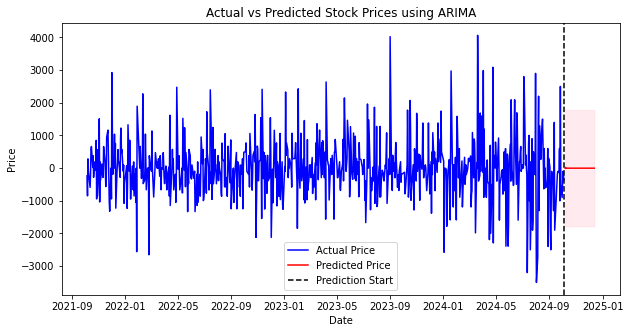

In [30]:
import matplotlib.pyplot as plt

# 예측 수행 (50일)
forecast_result = model_fit.get_forecast(steps=50)
forecast = forecast_result.predicted_mean
conf_int = forecast_result.conf_int()

# 예측 결과 시각화
plt.figure(figsize=(10, 5))
plt.plot(sam.index, sam['Adj Close_diff'], label='Actual Price', color='blue')  # 'data'를 'sam'으로 수정
plt.plot(pd.date_range(start=sam.index[-1], periods=51, freq='B')[1:], forecast, label='Predicted Price', color='red')
plt.fill_between(pd.date_range(start=sam.index[-1], periods=51, freq='B')[1:], conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='pink', alpha=0.3)
plt.axvline(x=sam.index[-1], color='black', linestyle='--', label='Prediction Start')
plt.title('Actual vs Predicted Stock Prices using ARIMA')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()


In [ ]:
import yfinance as yf

# 사용할 주식의 심볼 정의
ticker = 'AAPL'  # 예: 애플 주식

# 실제 데이터 가져오기
actual_data_last_50 = yf.download(ticker, start='2024-01-01', end='2024-03-01')
actual_last_50 = actual_data_last_50[['Close']]

print(actual_last_50)  # 실제 데이터 출력

In [ ]:
#실제 데이터와 비교 시각화
plt.figure(figsize=(10, 5))
plt.plot(actual_last_50.index, actual_last_50['Close'], label='Actual Price (Last 50 Days)', color='green')
plt.plot(pd.date_range(start=data.index[-1], periods=51, freq='B')[1:], forecast, label='Predicted Price (Last 50 Days)', color='red')
plt.fill_between(pd.date_range(start=df.index[-1], periods=51, freq='B')[1:], conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='pink', alpha=0.3)
plt.title('Comparison of Actual and Predicted Prices for the Last 50 Days using ARIMA')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

ARIMA에서는 성능이 왠지는 모르겠으나 잘 안 나와서 이정도만 하고 넘어가겠습니다. 밑에서 진행할 Prophet 모형의 경우 예측이 제대로 진행되어 추세를 예측하고자 단기적 예측이라 할 수 있는 50일이 아닌 향후 200일을 예측하였습니다.

### Prophet

Prophet 모델이란?
https://wikidocs.net/233162

In [ ]:
from prophet import Prophet

In [ ]:
###Prophet의 경우 ARIMA와 검정 및 전처리 과정이 약간 달라 새로 진행하였으며 보다 정확한 추세 예측을 위해 200일까지 예측하였습니다.###


ticker = 'AAPL'
data = yf.download(ticker, start='2019-01-01', end='2024-01-01')

df = data.reset_index()[['Date', 'Close']]
df.columns = ['ds', 'y']  #Prophet에서는 날짜 컬럼을 'ds', 값 컬럼을 'y'로 설정해야 함

In [ ]:
#모델 설정(파라미터는 따로 설정하지 않고 진행했으나 보다 정확한 예측을 위해 수정하는 것도 좋음)
model = Prophet()
model.fit(df)

In [ ]:
#200일간의 예측 진행
future = model.make_future_dataframe(periods=200)
forecast = model.predict(future)

In [ ]:
# 예측 결과 시각화
fig1 = model.plot(forecast)
plt.title('Apple Stock Price Prediction')
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()

In [ ]:
#트렌드 및 주기성 시각화
fig2 = model.plot_components(forecast)
plt.show()

In [ ]:
#마지막 200일의 실제 주가 데이터 가져오기
actual_data_last_50 = yf.download(ticker, start='2024-01-01', end='2024-08-01')
actual_last_50 = actual_data_last_50.reset_index()[['Date', 'Close']]
actual_last_50.columns = ['ds', 'y']

In [ ]:
#실제 값과 비교 시각화
plt.figure(figsize=(10, 5))
plt.plot(df['ds'], df['y'], label='Actual Price (2019-2024)', color='blue')

plt.plot(forecast['ds'][len(df):], forecast['yhat'][len(df):], label='Predicted Price', color='red') ##전체 예측값 중 200일 이후 것만 사용
plt.axvline(x=df['ds'].iloc[-1], color='black', linestyle='--', label='Prediction Start')
plt.plot(actual_last_50['ds'], actual_last_50['y'], label='Actual Price(200days)', color='green')
plt.title('Actual vs Predicted Apple Stock Prices')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()


예시에서는 전통적 시계열 모형인 ARIMA 보다 최신 기법인 Prophet이 보다 좋은 성능을 보였습니다. 

사실 ARIMA로도 좋은 예측을 진행할 수는 있으나 조금 간단하게 진행하였으며(죄송합니다..시간관계상 ㅠ) SARIMA, ARIMAX와 같이 발전된 모형을 사용하는 것도 방법입니다. 

예시보다 좋은 예측을 진행하여 주시길 바라며 단순히 시각화하는 것을 넘어서 ***RMSE***나 ***MAE***와 같은 성능지표를 활용해 정량적 평가를 진행해주시면 좋을 것 같습니다.